In [26]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Camera Calibration
***
We must first start with images that have all camera related distortion accounted for before further processing.

In [27]:
def calibrate_camera(calibration_dir, checker_grid_size=(9,6)):
    # read collection of checkerboard images and extract corners
    objpoints = []
    imgpoints = []
    
    (grid_x, grid_y) = checker_grid_size
    objp = np.zeros((grid_x * grid_y, 3), np.float32)
    objp[:,:2] = np.mgrid[0:grid_x, 0:grid_y].T.reshape(-1, 2)
    
    for cal_file in os.listdir(calibration_dir):
        path = os.path.join(calibration_dir, cal_file)
        img = cv2.imread(path)
        
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, checker_grid_size, None)
        
        if ret:
            imgpoints.append(corners)
            objpoints.append(objp)
        else:
            # Some images don't find the full 9x6 set of corners because they are cut off.
            # print here for warning though it isn't catastrophic.
            print("Failed to find checkerboard corners!:", cal_file)
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    
    return (mtx, dist) if ret else None

def undistort_image(img, cam_matrix, dist_params):
    return cv2.undistort(img, cam_matrix, dist_params, None, cam_matrix)

(cam_matrix, dist_params) = calibrate_camera('camera_cal')


Failed to find checkerboard corners!: calibration1.jpg
Failed to find checkerboard corners!: calibration4.jpg
Failed to find checkerboard corners!: calibration5.jpg


### Example: (note the lines have straightened out)
***

In [30]:
def before_after_plot(img_before, img_after, title_before, title_after):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img_before)
    ax1.set_title(title_before, fontsize=50)
    ax2.imshow(img_after)
    ax2.set_title(title_after, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)    

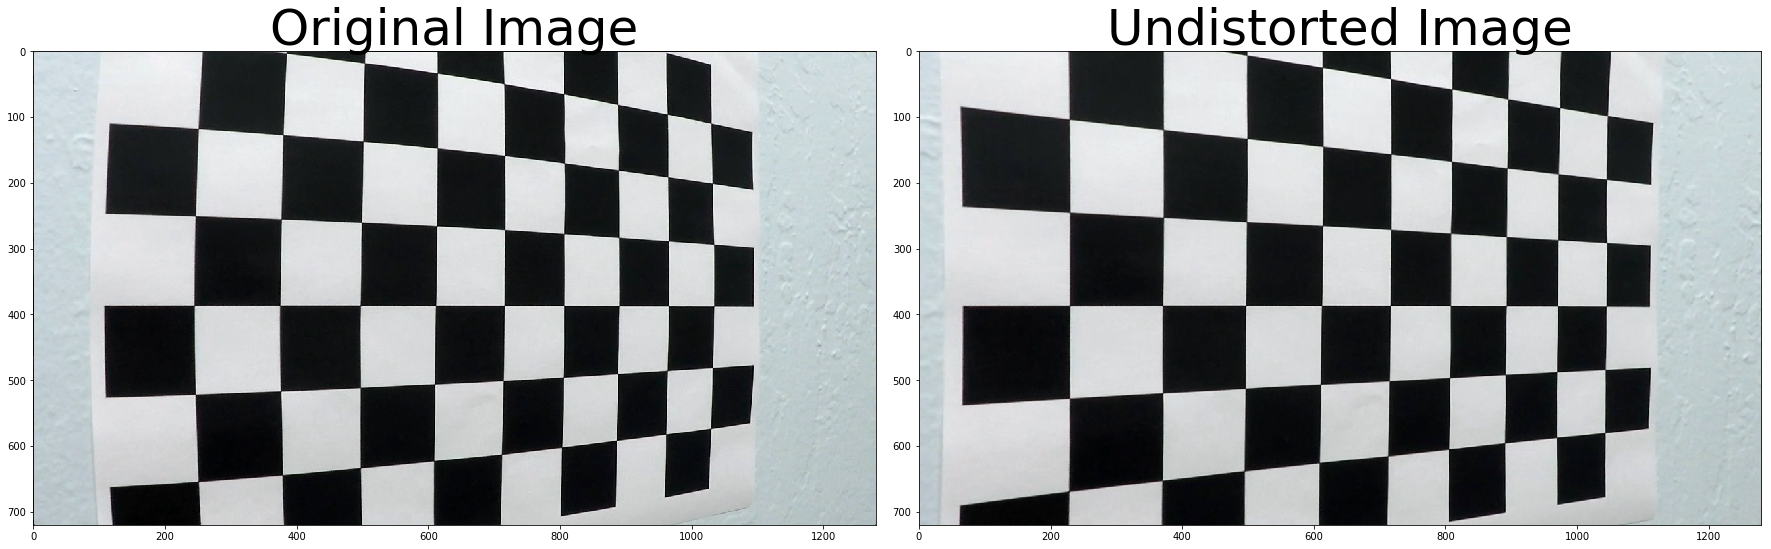

In [31]:
def ex1():
    img = cv2.imread('camera_cal/calibration5.jpg')
    before_after_plot(img, undistort_image(img, cam_matrix, dist_params), 'Original Image', 'Undistorted Image')
ex1()

# Perspective Transformation
***
It is easier to process the curvature of lane lines when viewed from the top down.  Let's use a perspective transform to accomplish this.  To do this, we need to establish a correspondence between four points in the camera image to where we want the four corresponding locations to be in the top down image.

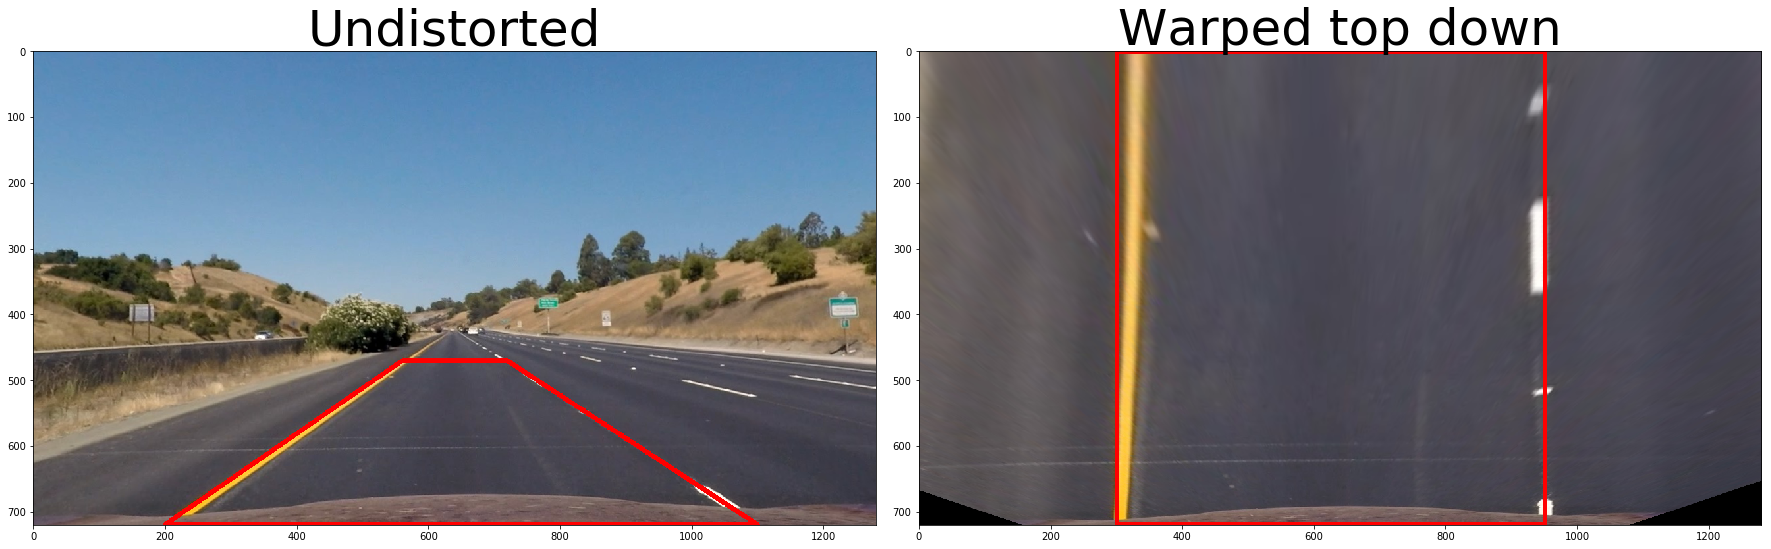

In [74]:
def ex2():
    img = plt.imread('test_images/straight_lines1.jpg')
    img = undistort_image(img, cam_matrix, dist_params)
    (height, width) = img.shape[:2]
    # bottom left, clockwise
    src_points = np.float32([(200, height-1), (560, 470), (720, 470), (1100, height-1)])
    dst_points = np.float32([(300, height-1), (300, 0),   (950, 0),   (950, height-1)])
    
    M = cv2.getPerspectiveTransform(src_points, dst_points)
    # This will be useful later when we want to remap back to original image.
    Minv = cv2.getPerspectiveTransform(src_points, dst_points)
    
    top_down = cv2.warpPerspective(img, M, (width, height), flags=cv2.INTER_LINEAR)
    cv2.polylines(img, [src_points.reshape((-1,1,2)).astype(np.int32)], True, color=(255,0,0), thickness=5)
    cv2.polylines(top_down, [dst_points.reshape((-1,1,2)).astype(np.int32)], True, color=(255,0,0), thickness=5)

    before_after_plot(img, top_down, 'Undistorted', 'Warped top down')
    
    return (M, Minv)
    
(perspM, perspMinv) = ex2()